In [1]:
## Our standard import
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
loaded_joblib = joblib.load('random_forest.joblib')
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForestRegressor'])

In [3]:
X_train_df = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test_df = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
reg = loaded_joblib['RandomForestRegressor']

# Explain your tree-based model with shap:

In [4]:
import shap
shap.initjs()

In [5]:
len(X_train_df)

6392

In [6]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4469         7.72         0.074669   76.3986                     1987.0   
4438         5.11         0.034868  163.8210                     2004.0   
366          8.05         0.078386  256.4646                     2004.0   
2219         8.76         0.050131  128.3336                     1999.0   
6080         6.59         0.176748   82.7908                     1998.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
4469                       0.0                       1.0   
4438                       1.0                       0.0   
366                        0.0                       1.0   
2219                       1.0                       0.0   
6080                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
4469                     0.0               1.0                  0.0   
4438                     0.0               0.0                  0.0   
366                      0.0               0.0                  0.0   
2219                     0.0               0.0                  0.0   
6080                     0.0               0.0                  0.0   

      Item_Type_Canned  ...  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
4469               0.0  ...                    0.0                      0.0   
4438               0.0  ...                    0.0                      0.0   
366                0.0  ...                    0.0                      0.0   
2219               0.0  ...                    0.0                      0.0   
6080               0.0  ...                    0.0                      0.0   

      Outlet_Size_High  Outlet_Size_MISSING  Outlet_Size_Medium  \
4469               1.0                  0.0                 0.0   
4438               0.0                  0.0                 0.0   
366                0.0                  0.0                 0.0   
2219               0.0                  0.0                 1.0   
6080               0.0                  1.0                 0.0   

      Outlet_Size_Small  Outlet_Type_Grocery Store  \
4469                0.0                        0.0   
4438                1.0                        0.0   
366                 1.0                        0.0   
2219                0.0                        0.0   
6080                0.0                        1.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4469                            1.0                            0.0   
4438                            1.0                            0.0   
366                             1.0                            0.0   
2219                            1.0                            0.0   
6080                            0.0                            0.0   

      Outlet_Type_Supermarket Type3  
4469                            0.0  
4438                            0.0  
366                             0.0  
2219                            0.0  
6080                            0.0  

[5 rows x 30 columns]

In [7]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 


4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
          ...    
215      131.1626
4680    2251.0698
1288    1834.9448
3635     759.0120
7936    4074.6960
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [8]:
explainer = shap.Explainer(reg)
explainer

In [9]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [10]:
X_shap.shape

(400, 30)

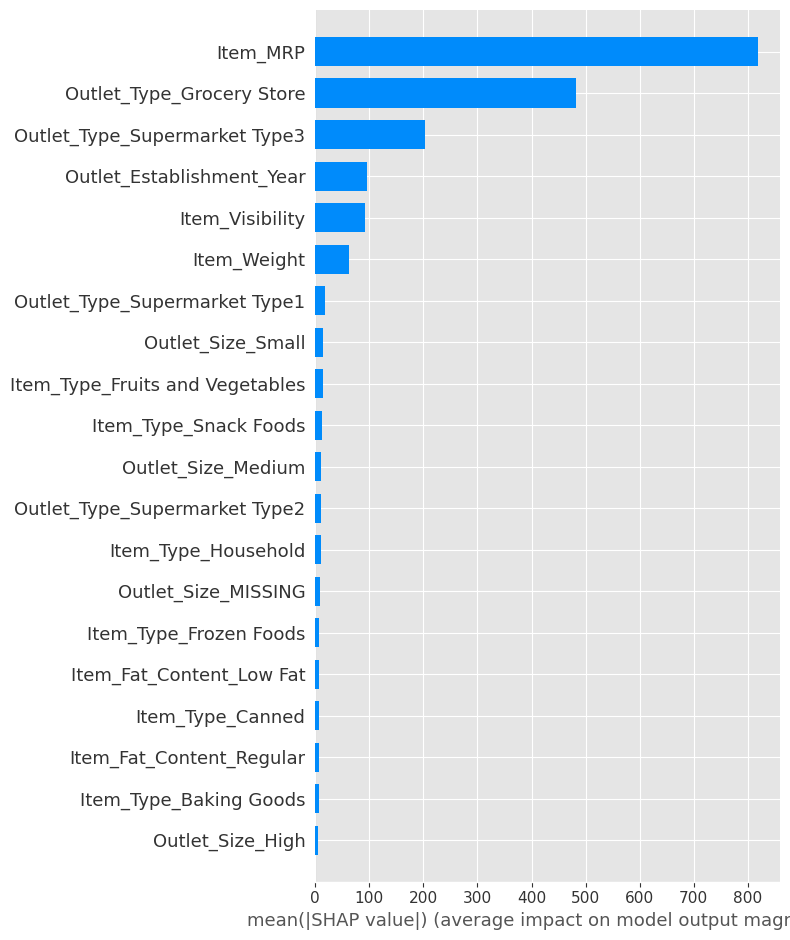

In [11]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, plot_type='bar')
#saving the summary plot
fig.savefig('Data/summary_plot_rf.png', bbox_inches="tight")

display feature importance image

<img src="https://github.com/ivyyyyyliu/Food-Sales-Prediction/blob/main/Data/importances.png"/>


They are not exactly the same, the first and the second are the same. In shap, the supermarket type 3 go up in to third place.
The item visibility went down to the last. However, we have new feature - Establishment Year.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


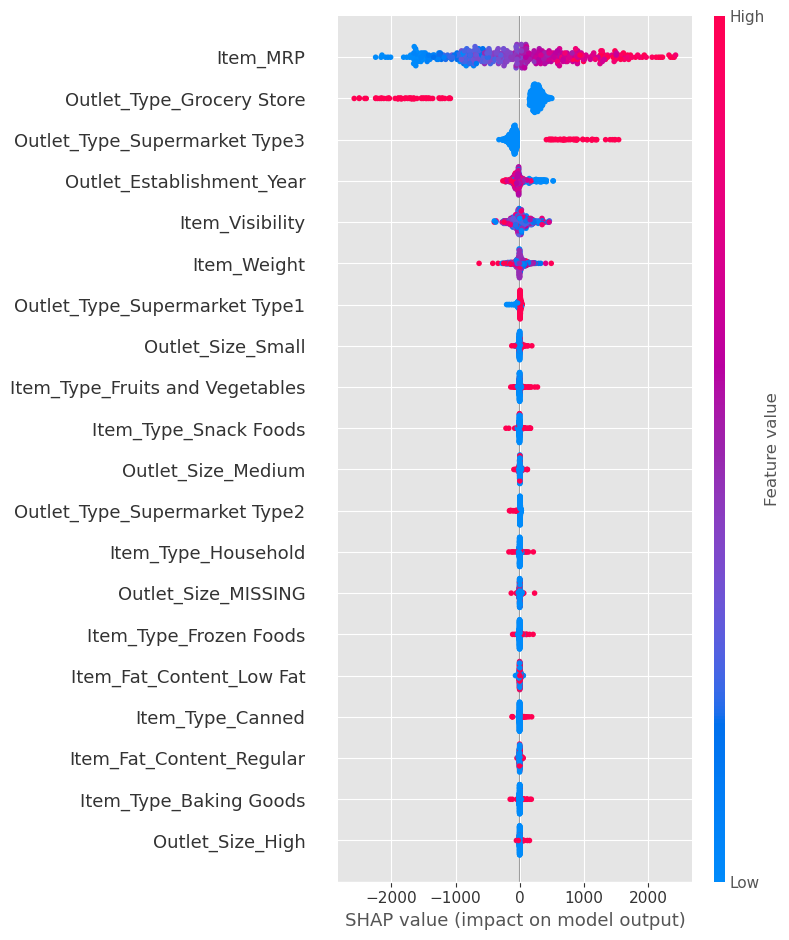

In [12]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, features = X_shap,plot_type='dot')
#saving
fig.savefig('Data/summary_plot_dot.png');

# Top 3 most important features

- Item MRP:
    - The Sales will be higher if the items prices are higher
- Outlet type Grocery Store
    - it will affect sales.
- Outlet type Supermarket Type 3
    - more supermarket type 3, it will increasing more sales. 

# Local Explanations

In [26]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0         7.72         0.074669   76.3986                     1987.0   
1         5.11         0.034868  163.8210                     2004.0   
2         8.05         0.078386  256.4646                     2004.0   
3         8.76         0.050131  128.3336                     1999.0   
4         6.59         0.176748   82.7908                     1998.0   

   Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  Item_Type_Baking Goods  \
0                       0.0                       1.0                     0.0   
1                       1.0                       0.0                     0.0   
2                       0.0                       1.0                     0.0   
3                       1.0                       0.0                     0.0   
4                       1.0                       0.0                     0.0   

   Item_Type_Breads  Item_Type_Breakfast  Item_Type_Canned  ...  \
0               1.0                  0.0               0.0  ...   
1               0.0                  0.0               0.0  ...   
2               0.0                  0.0               0.0  ...   
3               0.0                  0.0               0.0  ...   
4               0.0                  0.0               0.0  ...   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Outlet_Size_High  \
0                    0.0                      0.0               1.0   
1                    0.0                      0.0               0.0   
2                    0.0                      0.0               0.0   
3                    0.0                      0.0               0.0   
4                    0.0                      0.0               0.0   

   Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                1.0   
2                  0.0                 0.0                1.0   
3                  0.0                 1.0                0.0   
4                  1.0                 0.0                0.0   

   Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
0                        0.0                            1.0   
1                        0.0                            1.0   
2                        0.0                            1.0   
3                        0.0                            1.0   
4                        1.0                            0.0   

   Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
0                            0.0                            0.0  
1                            0.0                            0.0  
2                            0.0                            0.0  
3                            0.0                            0.0  
4                            0.0                            0.0  

[5 rows x 30 columns]

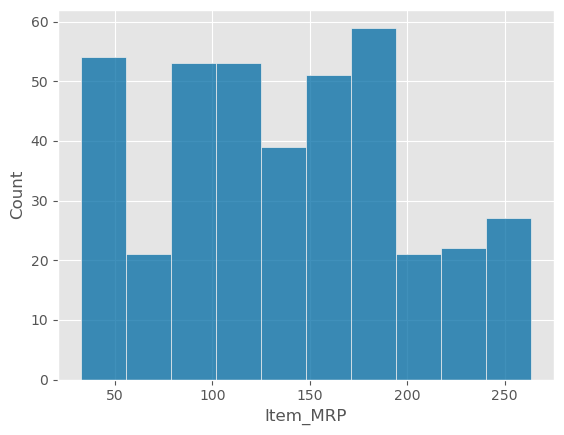

In [27]:
sns.histplot(X_shap['Item_MRP']);

In [40]:
high_mrp = X_shap_local['Item_MRP'].idxmax()
high_mrp

366

In [41]:
X_shap_local.iloc[high_mrp]

Item_Weight                          13.800000
Item_Visibility                       0.141235
Item_MRP                            263.788400
Outlet_Establishment_Year          1987.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       1.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   0.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 0.000000
Item_Type_Soft Drinks                 0.000000
Item_Type_Sta

In [42]:
y_shap_local.iloc[high_mrp]

5564.7564

In [47]:
low_mrp = X_shap_local['Item_MRP'].idxmin()
low_mrp

305

In [48]:
X_shap_local.iloc[low_mrp]

Item_Weight                          11.800000
Item_Visibility                       0.076657
Item_MRP                             32.355800
Outlet_Establishment_Year          1987.000000
Item_Fat_Content_Low Fat              0.000000
Item_Fat_Content_Regular              1.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       0.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   0.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 1.000000
Item_Type_Soft Drinks                 0.000000
Item_Type_Sta

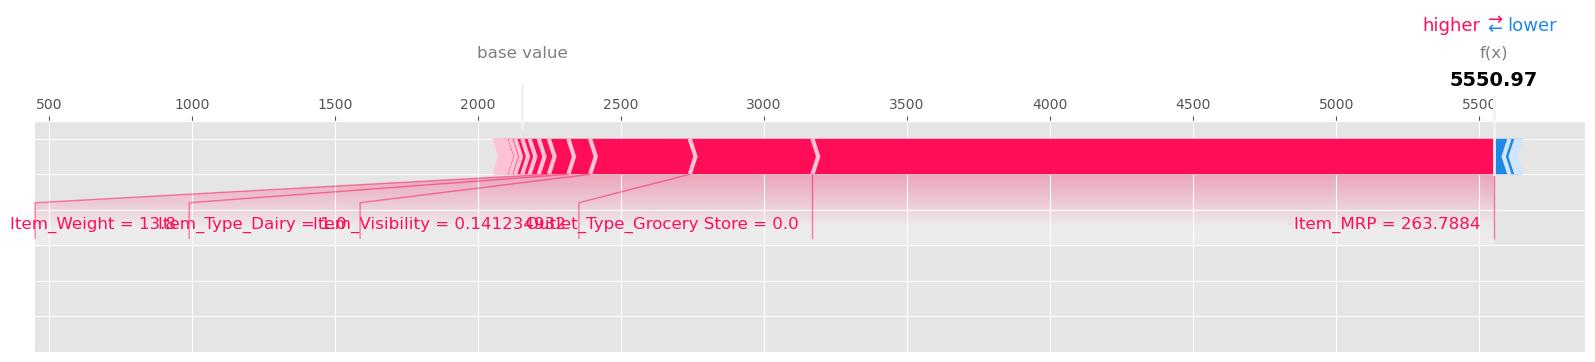

In [44]:
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[high_mrp].values,
               features=X_shap_local.iloc[high_mrp],show=False,matplotlib=True)

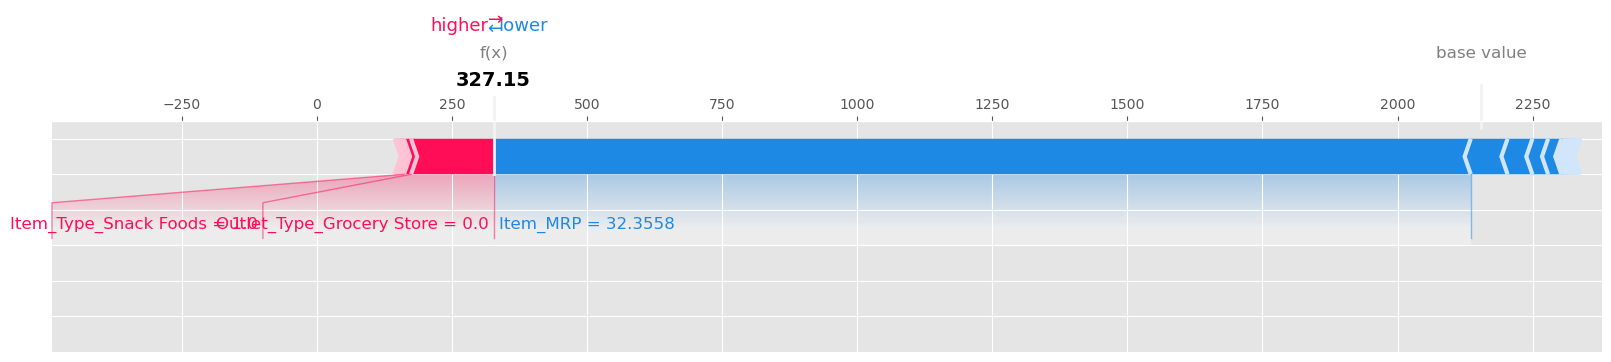

In [49]:
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[low_mrp].values,
               features=X_shap_local.iloc[low_mrp],show=False,matplotlib=True)

In [36]:
# LimeTabularExplainer
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap.values,
    feature_names=X_shap.columns,
    mode='regression')
lime_explainer

In [51]:
## Use the lime explainer to explain the selected example used above 

exp = lime_explainer.explain_instance(X_shap_local.loc[high_mrp],
                                      reg.predict)


exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [52]:
## Use the lime explainer to explain the selected example used above 

exp = lime_explainer.explain_instance(X_shap_local.loc[low_mrp],
                                      reg.predict)


exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
